# <center>CMSC320 Final Project - The Musk Effect</center>

<center>Michael Reeve and Sambit Sahoo</center>

## Introduction

In the age of social media and industry, Elon Musk has had a significant impact on our society. Unlike most CEOs, Elon Musk takes a more millennial-style approach and has a large social media presence. His Twitter account, @elonmusk, has over 120 million followers. Do Elon Musk’s tweets mainly have positive, negative, or neutral connotations? We will take a closer look at a dataset we found on Kaggle and data from our own data scraping using Twitter's API to examine the effect of Elon Musk’s tweets.

There are two specific timeframes we would like to investigate thoroughly. On April 4th, 2022, Elon Musk disclosed his stake in Twitter and Twitter announced that he would be joining the board of directors. During this time, did Elon Musk have positive sentiments with his tweets? The second timeframe is around October 28th, 2022. Elon Musk announced that he finalized a deal to acquire Twitter and begin internal processes that led to strife within the company due to layoffs and other reasons. Our motivation for this project is to see if Elon Musk's behavior changed when joining Twitter's board of directors and when he announced that he was acquiring Twitter.

This tutorial will guide you through the analysis of Elon Musk’s Twitter data and we will investigate his behavior through his tweets.

In [1]:
# imports
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date as dt, timedelta
import string
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt",
], quiet=True)
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import scipy.stats as stats

## Data Collection

For data collection, we decided to combine two methods. First, we found a dataset on [Kaggle](https://www.kaggle.com/datasets/marta99/elon-musks-tweets-dataset-2022) containing Elon Musk’s tweets from January 27th, 2022 to October 27th, 2022. Additionally, we data scraped data using Twitter’s API to get data from October 20th, 2022 to December 12th, 2022. We noticed that the tweets from October 20th, 2022 to October 27th, 2022 from the Kaggle dataset had fewer likes and retweets mainly because of the time the data was pulled, so it hasn’t updated to the number of likes and retweets his tweets currently have. The likes and retweets are much higher now than presented in the dataset, so we removed that data and used our data scraped information to replace it. Now, we have a dataset containing tweets from the Twitter API from October 20th, 2022 to December 11th, 2022 and tweets from Kaggle, spanning from January 27th, 2022 to October 19th, 2022.

The data collected from data scraping contained information regarding the unfiltered tweet, the date and time the tweet was created, the number of likes, and the number of retweets. The data collected from the Kaggle dataset included the unfiltered tweets, the number of retweets, the number of likes, the date and time of the tweet, and the cleaned tweet.

In [2]:
kaggle_df = pd.read_csv("cleandata.csv")
kaggle_df

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!
...,...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,171,3173,2022-01-27 22:01:06,Just that manganese is an alternative to iron ...
2664,@incentives101 @ICRicardoLara Exactly,145,4234,2022-01-27 21:23:20,Exactly
2665,@ICRicardoLara Your policies are directly resp...,421,6144,2022-01-27 21:13:57,Your policies are directly responsible for the...
2666,@ICRicardoLara You should be voted out of office,484,7029,2022-01-27 21:12:27,You should be voted out of office


This dataset contains 5 columns, raw text (Tweets), Retweets, Likes, Date, and Cleaned Tweets. The date entries contain the time of day and we only care about the date, so let's strip the time from these entries.

In [3]:
# convert date and time to just date
kaggle_df["Date"] = pd.to_datetime(kaggle_df["Date"]).dt.date
kaggle_df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26,Entering Twitter HQ – let that sink in!


In [4]:
print(kaggle_df["Date"].min(), kaggle_df["Date"].max())

2022-01-27 2022-10-27


This dataset only contains tweets from 1/27-10/27. Let's use the Twitter API to pull tweets after 10/20 through 12/12 to add more data to analyze.

The Kaggle dataset was compiled on 10/27, meaning the like and retweet counts are likely lower than what they would be today. We are assuming that most tweets approach a limit of likes and retweets after about a week of being posted. We are going to gather tweets from 10/20 onward and replace entries in the Kaggle dataset that overlap.

To use the Twitter API, we needed to create a developer app on [Twitter's website](https://developer.twitter.com/en). From there we can generate an API key (Bearer Token), this allows us to access the endpoints of the API. To safey share this code, we used a .env file to store the Bearer Token, loading it with the `load_dotenv` method from the `python-dotenv` package.

Next we need to use the 2/users/{id}/tweets endpoint. We will pass in our desired start time and end time to gather the correct tweets. However, this can only return 100 tweets at a time. To get around this we use a technique called [pagination](https://developer.twitter.com/en/docs/twitter-api/pagination), where the API will return the id of the next page to look at. So we send API requests with a different page until we are not given a new page to look at, signifying the end of the whole search.

To accomplish this, I created a loop that sends a new request until there are none left to make. Each request will generate a dataframe based on the results returned (in JSON). I then concatenated each requests' dataframe into the previous one, generating a complete dataframe at the end.

In [5]:
load_dotenv(".env")
token = os.environ.get("BEARER_TOKEN")
headers = {"Authorization": "Bearer {}".format(token)}

ELON_ID = "44196397"

search_url = "https://api.twitter.com/2/users/{}/tweets".format(ELON_ID)

query_params = {
    'start_time': '2022-10-20T00:00:00Z', # Look at tweets after 10/20/22
    'end_time': '2022-12-12T23:59:59Z', # Look at tweets before 12/13/22
    'tweet.fields': 'text,created_at,public_metrics', # Retreive text of tweet, date posted, metrics(likes, retweets)
    'max_results': 100, # get 100 tweets every request (this is the max Twitter allows)
}

api_df = pd.DataFrame()

# because we cannot download all tweets at once, we will continue making requests using a technique called pagination (link me)
next_token = ""
while next_token is not None:
    curr_params = query_params.copy()
    if next_token != "":
        curr_params['pagination_token'] = next_token

    # make request to twitter api
    res = requests.request("GET", search_url, headers = headers, params = curr_params)
    res_json = res.json()

    # end of loop check - more on this below
    if 'data' not in res_json:
        next_token = None
        continue
    
    # remove fields Twitter gives back to us that we don't need and de-construct metrics dict
    tweets = res_json['data']
    for t in tweets:
        if 'edit_history_tweet_ids' in t:
            del t['edit_history_tweet_ids']
        if 'id' in t:
            del t['id']
        if 'public_metrics' in t:
            metrics = t['public_metrics']
            t['likes'] = metrics['like_count']
            t['retweets'] = metrics['retweet_count']
            del t['public_metrics']

    # create dataframe out of current 100 tweets then add to cumulative df
    curr_df = pd.DataFrame().from_dict(tweets)
    api_df = pd.concat([api_df, curr_df])

    # check if the next page exists, if not we end the loop by setting next_token to None
    if 'meta' in res_json:
        if 'next_token' in res_json['meta']:
            next_token = res_json['meta']['next_token']
        else:
            next_token = None
    else:
        next_token = None

print(len(api_df), "Tweets")
api_df.head()

1501 Tweets


,text,created_at,likes,retweets
0,@Lukewearechange @AndrewPollackFL Accurate,2022-12-12T22:15:25.000Z,39118,2894
1,@BillyM2k Haha totally. High quality bots are ...,2022-12-12T21:40:20.000Z,11877,599
2,@rupasubramanya @TheFP Exactly,2022-12-12T21:34:51.000Z,35007,2399
3,@TRHLofficial @ggreenwald Indeed,2022-12-12T21:14:47.000Z,11752,661
4,@micsolana The wording is mine lol,2022-12-12T20:56:45.000Z,78755,2613


In [6]:
#confirm tweets from the proper date range were retrieved
print("Min:", api_df["created_at"].min(), "  Max:", api_df["created_at"].max()) 

Min: 2022-10-20T00:10:14.000Z   Max: 2022-12-12T22:15:25.000Z


The Twitter API also pulls retweets from the given user, they are defined as the text starting with "RT @" and having 0 likes, let's see how many there are.

In [7]:
api_df[(api_df["text"].apply(lambda x: str(x).startswith("RT @"))) & (api_df["likes"] == 0)]

,text,created_at,likes,retweets
57,RT @SpaceX: Deployment of ispace’s HAKUTO-R Mi...,2022-12-11T08:27:27.000Z,0,3943
63,RT @SpaceX: Watch Falcon 9 launch ispace’s HAK...,2022-12-11T07:56:19.000Z,0,3850
64,RT @SpaceX: Falcon 9’s first stage has landed ...,2022-12-11T07:56:16.000Z,0,3484
65,RT @SpaceX: Liftoff! https://t.co/FEenmAJmOz,2022-12-11T07:56:14.000Z,0,5284
69,"RT @CommunityNotes: Beginning today, Community...",2022-12-11T01:45:21.000Z,0,4538
...,...,...,...,...
59,RT @Tesla: Vote for new Supercharger locations...,2022-10-21T21:46:05.000Z,0,2285
60,"RT @Tesla: Our most advanced paint system yet,...",2022-10-21T21:45:15.000Z,0,1530
70,RT @Tesla: https://t.co/CqbkkORG70,2022-10-21T06:01:32.000Z,0,2651
94,RT @SpaceX: Deployment of 54 Starlink satellit...,2022-10-20T16:05:22.000Z,0,2141


Let's remove those.

In [8]:
api_df = api_df[~((api_df["text"].apply(lambda x: str(x).startswith("RT @"))) & (api_df["likes"] == 0))]
api_df

,text,created_at,likes,retweets
0,@Lukewearechange @AndrewPollackFL Accurate,2022-12-12T22:15:25.000Z,39118,2894
1,@BillyM2k Haha totally. High quality bots are ...,2022-12-12T21:40:20.000Z,11877,599
2,@rupasubramanya @TheFP Exactly,2022-12-12T21:34:51.000Z,35007,2399
3,@TRHLofficial @ggreenwald Indeed,2022-12-12T21:14:47.000Z,11752,661
4,@micsolana The wording is mine lol,2022-12-12T20:56:45.000Z,78755,2613
...,...,...,...,...
98,@marenkahnert @jasondebolt Exactly,2022-10-20T07:57:25.000Z,1934,79
99,@Teslarati @13ericralph31 SpaceX has more acti...,2022-10-20T07:30:52.000Z,16127,1386
0,@jasondebolt The media reports with great fanf...,2022-10-20T06:52:01.000Z,23005,1490
1,@jakebrowatzke @andyjayhawk 🤣,2022-10-20T06:38:51.000Z,1950,78


The ```created_at``` column contains the date and time a tweet was created. We only care about the date so let's strip the date and time down to date, then rename the column to "date"

In [9]:
api_df["date"] = pd.to_datetime(api_df["created_at"]).dt.date
api_df = api_df.drop(columns="created_at")
api_df.head()

,text,likes,retweets,date
0,@Lukewearechange @AndrewPollackFL Accurate,39118,2894,2022-12-12
1,@BillyM2k Haha totally. High quality bots are ...,11877,599,2022-12-12
2,@rupasubramanya @TheFP Exactly,35007,2399,2022-12-12
3,@TRHLofficial @ggreenwald Indeed,11752,661,2022-12-12
4,@micsolana The wording is mine lol,78755,2613,2022-12-12


Now lets combine the two datasets.

Our first step is to remove entries after 10/19 from the Kaggle dataset, these will be replaced by the Twitter API dataset.

In [10]:
kaggle_df = kaggle_df[~(kaggle_df["Date"] > dt(2022,10,19))]
kaggle_df

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
95,@westcoastbill Will require truly exceptional ...,745,11060,2022-10-19,"Will require truly exceptional execution, but ..."
96,"I will not let you down, no matter what it takes",35111,392237,2022-10-19,"I will not let you down, no matter what it takes"
97,@DirtyTesLa Awesome,88,2381,2022-10-19,Awesome
98,We even did a Starlink video call on one airpl...,2060,37029,2022-10-19,We even did a Starlink video call on one airpl...
99,Vox Populi Vox Dei,5709,53880,2022-10-19,Vox Populi Vox Dei
...,...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,171,3173,2022-01-27,Just that manganese is an alternative to iron ...
2664,@incentives101 @ICRicardoLara Exactly,145,4234,2022-01-27,Exactly
2665,@ICRicardoLara Your policies are directly resp...,421,6144,2022-01-27,Your policies are directly responsible for the...
2666,@ICRicardoLara You should be voted out of office,484,7029,2022-01-27,You should be voted out of office


Then we need to rename and reorder the columns so that they match the Twitter API datset, as well as drop the `Cleaned_Tweets` column in the Kaggle dataset (we will implement our own cleaning later).

In [11]:
tmp_kaggle_df = kaggle_df.drop(columns="Cleaned_Tweets")
tmp_kaggle_df.columns = ["text", "retweets", "likes", "date"]

tmp_kaggle_df = tmp_kaggle_df[["text", "date", "likes", "retweets"]]

df = pd.concat([api_df,tmp_kaggle_df])
df

,text,likes,retweets,date
0,@Lukewearechange @AndrewPollackFL Accurate,39118,2894,2022-12-12
1,@BillyM2k Haha totally. High quality bots are ...,11877,599,2022-12-12
2,@rupasubramanya @TheFP Exactly,35007,2399,2022-12-12
3,@TRHLofficial @ggreenwald Indeed,11752,661,2022-12-12
4,@micsolana The wording is mine lol,78755,2613,2022-12-12
...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,3173,171,2022-01-27
2664,@incentives101 @ICRicardoLara Exactly,4234,145,2022-01-27
2665,@ICRicardoLara Your policies are directly resp...,6144,421,2022-01-27
2666,@ICRicardoLara You should be voted out of office,7029,484,2022-01-27


In [12]:
# confirm date range is 1/27 - today
print("Min:", df["date"].min(), "  Max:", df["date"].max())

Min: 2022-01-27   Max: 2022-12-12


We now have a combined dataset that we can start to use in our analysis!

## Data Curation

For the data obtained from both methods, we only need to keep the date of the tweet for future analysis, removing the time of the tweet. The number of likes and retweets remained untouched. We got rid of the cleaned tweets column from the Kaggle dataset since we will use our own cleaner on the original tweet. Also, we noticed that ampersand symbols appeared as "&amp" in the original tweet, so we replaced that with just the ampersand symbol, "&". In the tweets obtained from Twitter’s API, it includes retweets, which we don’t need. We removed the 72 instances of retweets.
 
Now, we can combine the two datasets in one dataframe. We looked at the contents of the tweets. In each tweet, it may include mentions of other users, indicated by @ followed by a username (e.g. “@cmsc320”, “@maxiscool”), links to other tweets, websites, and media like images or videos. We need to remove that from the text field.    

In [13]:
df["cleaned_text"] = df["text"].apply(lambda x: re.sub(r'@\w+', "", x))
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: re.sub(r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)', "", x))
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: x.replace("&amp;", "&"))
df.head()

,text,likes,retweets,date,cleaned_text
0,@Lukewearechange @AndrewPollackFL Accurate,39118,2894,2022-12-12,Accurate
1,@BillyM2k Haha totally. High quality bots are ...,11877,599,2022-12-12,Haha totally. High quality bots are fine!
2,@rupasubramanya @TheFP Exactly,35007,2399,2022-12-12,Exactly
3,@TRHLofficial @ggreenwald Indeed,11752,661,2022-12-12,Indeed
4,@micsolana The wording is mine lol,78755,2613,2022-12-12,The wording is mine lol


## Exploratory Data Analysis

Now that we have scraped, parsed, and cleaned the data, we have a dataframe of Elon Musk's tweets to work with. We can begin exploring our dataframe using matplotlib to visualize our data.

Did Elon Tweet every day from 1/27 until today? In order to find out, we need to find the difference in every day in that range and the unique values from the date column. This will be helpful later when we plot data.

In [14]:
min_date = df["date"].min()
max_date = df["date"].max()
time_delta = max_date - min_date

all_dates = [min_date + timedelta(x) for x in range(time_delta.days + 1)]
all_dates

diff_in_dates = set(all_dates) - set(df["date"].unique().tolist())
print("There are " + str(len(diff_in_dates)) + " days when Elon Musk did not post a tweet.")
diff_in_dates

There are 23 days when Elon Musk did not post a tweet.


{datetime.date(2022, 2, 24),
 datetime.date(2022, 2, 27),
 datetime.date(2022, 3, 23),
 datetime.date(2022, 4, 11),
 datetime.date(2022, 4, 12),
 datetime.date(2022, 4, 13),
 datetime.date(2022, 5, 5),
 datetime.date(2022, 6, 22),
 datetime.date(2022, 6, 23),
 datetime.date(2022, 6, 24),
 datetime.date(2022, 6, 25),
 datetime.date(2022, 6, 26),
 datetime.date(2022, 6, 27),
 datetime.date(2022, 6, 28),
 datetime.date(2022, 6, 29),
 datetime.date(2022, 6, 30),
 datetime.date(2022, 7, 1),
 datetime.date(2022, 7, 3),
 datetime.date(2022, 7, 9),
 datetime.date(2022, 7, 10),
 datetime.date(2022, 7, 17),
 datetime.date(2022, 8, 3),
 datetime.date(2022, 9, 2)}

Looks like Elon did not tweet on 23 days. He took a 9 day break from June 22th to June 30th, 2022.

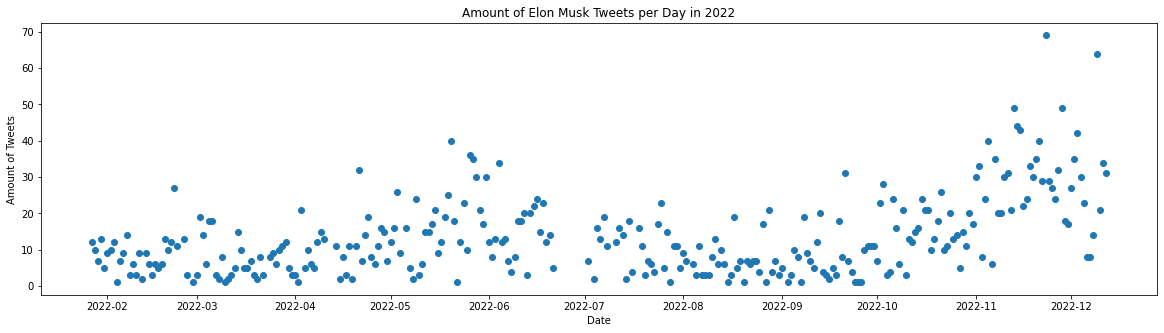

count    297.000000
mean      13.474747
std       10.909031
min        1.000000
25%        5.000000
50%       11.000000
75%       19.000000
max       69.000000
Name: text, dtype: float64

In [15]:
dates_count_group = df.groupby(by="date", as_index=False).count()

plt.figure(figsize=(20,5))
plt.scatter(dates_count_group["date"], dates_count_group["text"])
plt.title("Amount of Elon Musk Tweets per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Tweets")
plt.show()
display(dates_count_group["text"].describe())

In this scatterplot, we are examining the amount of time Elon Musk tweets per day in 2022. On average, Elon Musk tweets around 13.54 times a day in 2022. Elon Musk typically tweets about 5 to 19 times a day. In November and December, there is an uptick in the number of times he tweets. His highest amount of tweets in a day were on November 23rd and December 9th, when he tweeted 69 and 64 times, respectively. 

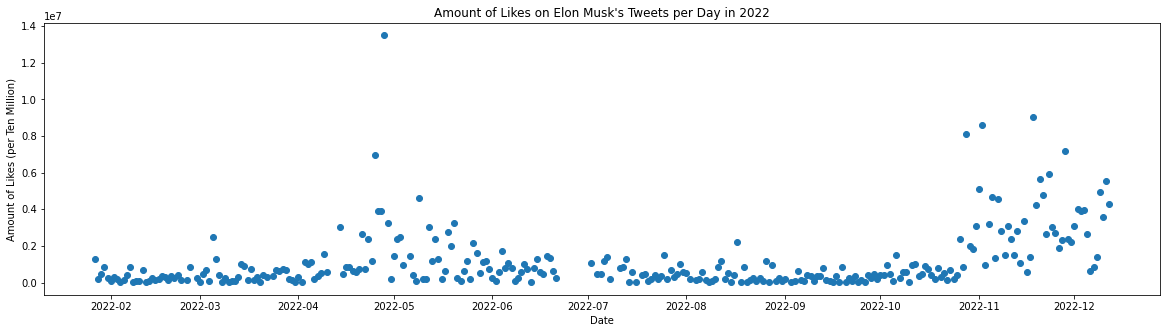

count    2.970000e+02
mean     1.139910e+06
std      1.658872e+06
min      3.664000e+03
25%      2.044820e+05
50%      5.500210e+05
75%      1.274600e+06
max      1.349880e+07
Name: likes, dtype: float64

In [16]:
dates_sum_group = df.groupby(by="date", as_index=False).sum()

plt.figure(figsize=(20,5))
plt.scatter(dates_sum_group["date"], dates_sum_group["likes"])
plt.title("Amount of Likes on Elon Musk's Tweets per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Likes (per Ten Million)")
plt.show()
dates_sum_group["likes"].describe()

In this scatterplot, we are visualizing the amount of likes Elon Musk's tweets get per day. On average, Elon Musk gets 1139008 likes on tweets per day. The median likes per day on tweets is 550783 likes. The likes on April 25th and 28th and a majority of days November and December On April 28th, 2022 skew the mean amount of likes Elon Musk gets since there are significantly higher than the normal amount. On April 25th, he tweets 8 times and got 6942305 likes. On April 28th, he tweets 16 times and got 13498798 likes, his all-time high in 2022. On his highly-liked days in October and November, there is a possibility that he got more likes because he tweeted more times on those days than usual as illustrated in the previous scatterplot. 

,date,likes,retweets,text,likes/tweets
82,2022-04-25,6942305,789375,8,867788.125000
83,2022-04-26,3910184,401710,6,651697.333333
85,2022-04-28,13498798,1307664,16,843674.875000
251,2022-10-28,8103005,882589,15,540200.333333


count       297.000000
mean      79502.281934
std       98493.597075
min        3664.000000
25%       26233.318182
50%       53479.363636
75%       98959.571429
max      867788.125000
Name: likes/tweets, dtype: float64

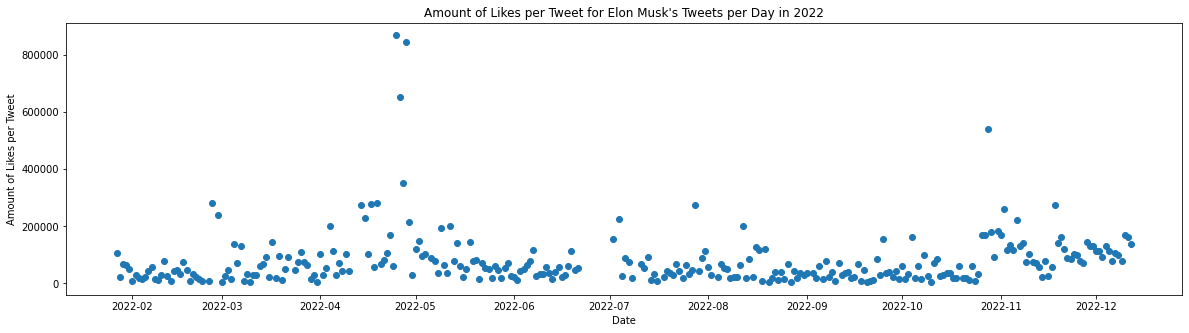

In [17]:
df_likes_to_tweets = dates_sum_group.copy()
df_likes_to_tweets["text"] = dates_count_group["text"]
df_likes_to_tweets["likes/tweets"] = df_likes_to_tweets.apply(lambda x: x["likes"]/x["text"], axis=1)

display(df_likes_to_tweets[df_likes_to_tweets["likes/tweets"] > 500000])
display(df_likes_to_tweets["likes/tweets"].describe())

plt.figure(figsize=(20,5))
plt.scatter(df_likes_to_tweets["date"], df_likes_to_tweets["likes/tweets"])
plt.title("Amount of Likes per Tweet for Elon Musk's Tweets per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Likes per Tweet")
plt.show()

In this scatterplot, we are looking at the ratio of Elon Musk's likes per tweet for each day in 2022. This visualization gives us a better idea of how many likes he gets per tweets compared to the last one because it gets rid of the variance of how often he tweeted on a given day. There were 4 specific days where his likes to tweet ratio was unusually high. On April 25th, 26th, 28th, and October 28th, he had over 500 thousand likes per tweet. This raises a few questions. Did something significant happened in those time periods? On October 28th, Elon Musk had announced that he was finalizing a deal to acquire Twitter and that might've had some influence on his account. On average, Elon Musk averages 79504.39 likes per tweet in 2022.

We want to discover Elon's must tweeted words. To do this, we need to filter out common words such as "as", "the", "or", etc. We also want to remove any punctuation. We will store these words to be filtered in a set of stopwords. We will combine what the NTLK module provides for english stopwords and punctuation provided by the string module.

Then we will use WordCloud to create a worldcloud image representing all of the words not in the stopwords that Elon used in his tweets, the size of the word represents how often the word appears.

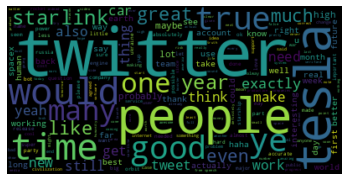

In [18]:
# create stopword list & wordcloud:
stops = set(stopwords.words('english') + list(string.punctuation))
# extra punctuation added to stopwords (weird ASCII chars, etc.)
stops.add("amp")
stops.add("…")
stops.add("’")
stops.add("“")
stops.add("”")

# create a single string of all of the tweets
all_text = " ".join(tweet.lower() for tweet in df["cleaned_text"])
wordcloud = WordCloud(stopwords=stops).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the WordCloud we can see that "Twitter" was Elon's most tweeted word, followed by "Tesla", "people", and "would". Some other notable words are "ye" (Kanye), and "starlink" (Elon's product to provide the globe with satalite internet).

In [19]:
all_tweets = df["cleaned_text"].str.cat(sep=" ").strip()
words = [word.lower() for word in nltk.word_tokenize(all_tweets) if word not in stops]

finder = nltk.collocations.TrigramCollocationFinder.from_words(words)
finder.ngram_fd.most_common(10)

[(('woke', 'mind', 'virus'), 6),
 (('make', 'life', 'multiplanetary'), 6),
 (('tesla', 'ai', 'day'), 6),
 (('the', 'new', 'york'), 5),
 (('new', 'york', 'times'), 5),
 (('result', 'account', 'suspension'), 5),
 (('needed', 'make', 'life'), 4),
 (('incitement', 'violence', 'result'), 4),
 (('the', 'twitter', 'files'), 4),
 (('hate', 'speech', 'impressions'), 4)]

This chunk of code finds the most common 3 word phrases throughout all of Elon's tweets. We notice some interesting phrases like "woke mind virus" and "hate speech impressions" appear more than 4 times throughout his tweets.

Next, we want to run sentiment analysis on Elon's Tweets. We are going to determine how many of Elon's tweets were either negative, neutral, or positive. 

To do so, we are using `SentimentIntensityAnalyzer` from the NLTK module. This sentiment analyzer is using [VADER](https://github.com/cjhutto/vaderSentiment) under the hood, which has been trained for small social media posts, like Tweets!

We can get a polarity score for a given string using the `polarity_scores` method. This will return a compound score between -1 and 1. We defined our bounds for a negative tweet as [-1, -0.05), neutral tweet as [-0.05, 0.05], and positive tweet as (0.05, 1].

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

scores = df["cleaned_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

df["neg"] = scores.apply(lambda x: 1 if x < -0.05 else 0)
df["neu"] = scores.apply(lambda x: 1 if x >= -0.05 and x <= 0.05 else 0)
df["pos"] = scores.apply(lambda x: 1 if x > 0.05 else 0)

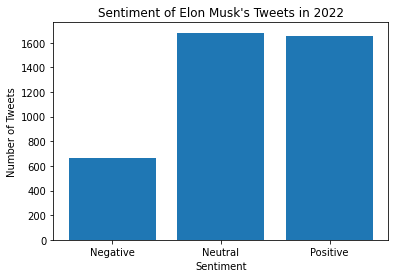

In [21]:
values = [df["neg"].sum(), df["neu"].sum(), df["pos"].sum()]
plt.bar(x=["Negative", "Neutral", "Positive"], height=values)
plt.title("Sentiment of Elon Musk's Tweets in 2022")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

This bar chart shows the overall sentiment for Elon Musk's tweets in 2022. The sentiments range from negative, neutral, and positive. From the graph, we can deduce that a majority of his tweets were neutral and positive, sprinkled with negative connotated tweets. We will break this down further and see if it varies in certain months and if there is a general trend in the sentiments of his tweets.

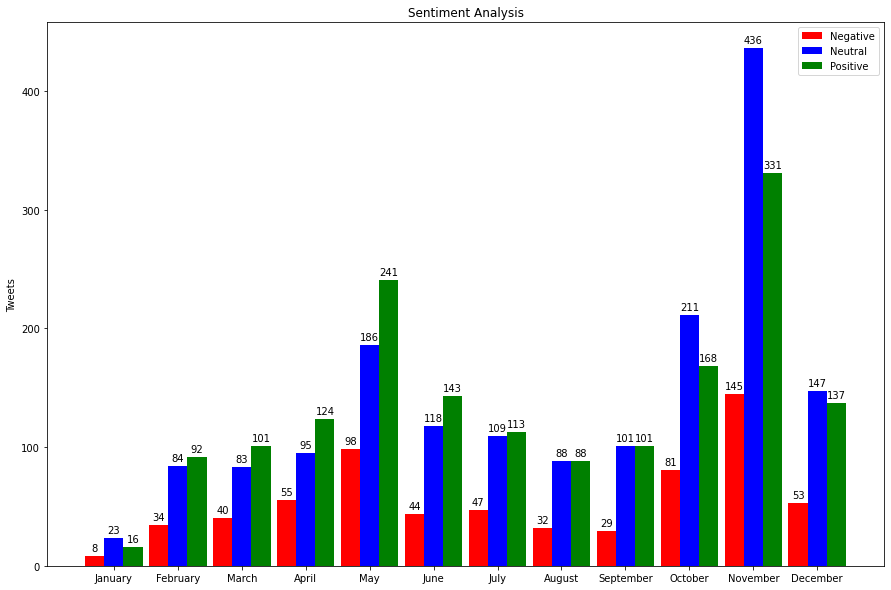

In [22]:
labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
pos = [0]*12
neg = [0]*12
neutral = [0]*12
for index, row in df.iterrows():
    date = int(row['date'].month)
    if row['pos'] == 1:
        pos[date - 1] = pos[date - 1] + 1
    elif row['neg'] == 1:
        neg[date - 1] = neg[date - 1] + 1
    elif row['neu'] == 1:
        neutral[date - 1] = neutral[date - 1] + 1

x = np.arange(len(labels))  
width = 0.3  

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
rects1 = ax.bar(x - width, neg, width, label='Negative', color='red')
rects2 = ax.bar(x, neutral, width, label='Neutral', color='blue')
rects3 = ax.bar(x + width, pos, width, label='Positive', color='green')

# text for labels, title and custom x,y-axis tick labels
ax.set_ylabel('Tweets')
ax.set_title('Sentiment Analysis')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

plt.show()

In this grouped bar chart, we broke Elon Musk's tweets into groups based on the month and the sentiment. For each month, we split the tweets based on positive, negative, and neutral sentiment to see if there was a general trend. In January, the tweet count is very low because the data was being pulled January 27th onwards, so there is not many tweets from the back end of January. Generally, the neutral and positive sentiment tweets dominate the negative sentiment tweets. 

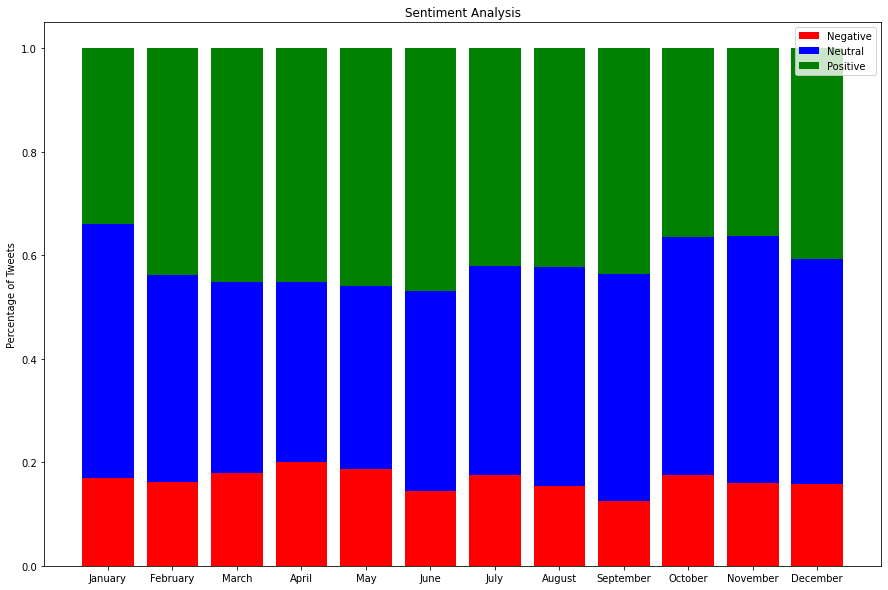

In [23]:
labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
total = [0]*12
for index in range(0,len(pos)):
    total[index] = pos[index] + neg[index] + neutral[index]
    pos[index] = float(pos[index])/total[index]
    neg[index] = float(neg[index])/total[index]
    neutral[index] = float(neutral[index])/total[index]

x = np.arange(len(labels))  
width = 0.3 

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

rand = [0]*12
for index in range(0,len(pos)):
    rand[index] = neg[index]+neutral[index]
plt.bar(x, neg, color='r')
plt.bar(x, neutral, bottom=neg, color='b')
plt.bar(x, pos, bottom=rand,color='g')

# text for labels, title and custom x,y-axis tick labels
plt.ylabel('Percentage of Tweets')
plt.title('Sentiment Analysis')
plt.xticks(x, labels)
plt.legend(['Negative','Neutral','Positive'])

plt.show()

This stacked bar chart is another way of representing the grouped bar chart from above. Instead of counting tweets, it calculates the percentage of each sentiment in a month. The negative sentiment tweets doesn't exceed 21%. The neutral sentiment tweets range between 34 to 49%. The positive sentiment tweets range from 34 to 46%. 

# Hypothesis Testing

Now that we know what our data looks like, we can begin forumlating a hypothesis about our data. We've seen surges in his tweet interactions, likes and retweets, during several timeframes. Using other information, we know Elon Musk joined Twitter's board of directors on April 4th, 2022 and he was acquiring Twitter on October 28th, 2022. So, let's create a hypothesis revolving around this.

The timeframes we will use for this test is 3 days before and 7 days after the date in question. So the timeframe ranges will be April 1st to April 11th and October 25th to November 4th. For the normal timeframe, we will pick a range in between of the two important dates, so July 7th to July 17th.

Hypothesis: There is a statistical significant difference in Elon Musk's tweets during a normal 11 day span and timeframes where he made a major business announcement.

We can begin examining the data, then run a hypothesis test.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


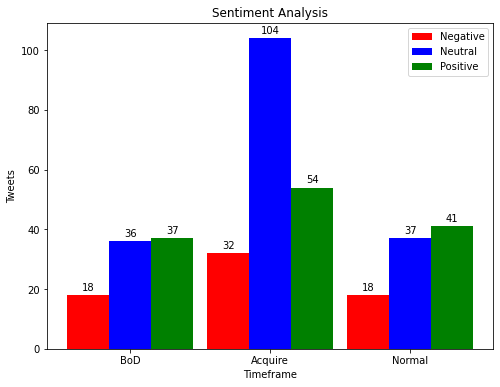

In [24]:
df_test1 = df[(df["date"] >= dt(2022, 4, 1)) & (df["date"] <= dt(2022, 4, 11))]
df_test2 = df[(df["date"] >= dt(2022, 10, 25)) & (df["date"] <= dt(2022, 11, 4))]
df_test3 = df[(df["date"] >= dt(2022, 7, 7)) & (df["date"] <= dt(2022, 7, 17))]


neg = list()
pos = list()
neu = list()
for d in [df_test1,df_test2,df_test3]:
    neg_val = d.groupby(by=['neg']).count()
    pos_val = d.groupby(by=['pos']).count()
    neu_val = d.groupby(by=['neu']).count()
    neg.append(neg_val['text'][1])
    pos.append(pos_val['text'][1])
    neu.append(neu_val['text'][1])

labels = ['BoD','Acquire','Normal']
x = np.arange(len(labels))  
width = 0.3  

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)

# text for labels, title and custom x,y-axis tick labels
ax.set_ylabel('Tweets')
ax.set_xlabel('Timeframe')
ax.set_title('Sentiment Analysis')
ax.set_xticks(x, labels)
ax.legend()

rects1 = ax.bar(x - width, neg, width, label='Negative', color='red')
rects2 = ax.bar(x, neu, width, label='Neutral', color='blue')
rects3 = ax.bar(x + width, pos, width, label='Positive', color='green')
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.legend(['Negative','Neutral','Positive'])

plt.show()

BoD represents the timeframe when Elon Musk joined Twitter's board of directors. Acquire represents the timeframe when he announced the acquisition of Twitter. Normal represents the timeframe in the middle of July. This visualization shows that the BoD and normal timeframe have almost identical results. For the Acquire timeframe, we can see that there is a difference in the neutral tweets, but the ratio of negative to positive is roughly the same.

To test our hypothesis, we will run an ANOVA test to determine if there is a statistically significant difference between the three timeframes. 

In [25]:
neg_3_groups = neg.copy()
neu_3_groups = neu.copy()
pos_3_groups = pos.copy()


neg_val = df_test3.groupby(by=['neg']).count()
pos_val = df_test3.groupby(by=['pos']).count()
neu_val = df_test3.groupby(by=['neu']).count()
neg_3_groups.append(neg_val['text'][1])
pos_3_groups.append(pos_val['text'][1])
neu_3_groups.append(neu_val['text'][1])

groups = np.transpose(np.array([neg_3_groups,neu_3_groups,pos_3_groups]))

# anova test for 3-way t-test
anova = stats.f_oneway(groups[0],groups[1],groups[2])
print("F-statistic:", anova[0])
print("p-Value:", anova[1])

F-statistic: 1.912090163934427
p-Value: 0.2278057985849194


So, we got a p-value of 0.228. Since the p-value is larger than significance value of 0.05, we fail to reject the null hypothesis. Therefore, there is no statistical significant difference between the three different timeframes. There is no statistical significant difference in Elon Musk's tweets during a normal 11 day span and timeframes where he made a major business announcement.

# Conclusion

This tutorial guided you through an in-depth analysis of Elon Musk's tweets and here are some important takeaways:
- He posts more positive or neutral tweets than negative
- He is influential, reflected on his large social media presence through his followers, likes, and retweets
- He tweets very often and likes to mention Twitter, Tesla, Starlink, "people", and "time"
- There was no statistical significant difference in his tweets in various timeframes

In this tutorial, we demonstrated several ways to collect data. We used a combination of finding a dataset on Kaggle and using the Twitter API to gather useful data. Throughout our data exploration, we used a variety of charts to illustrate our data, ranging from scatterplots to various bar graphs. 

There are several routes to take for further investigation. Although this analysis is contrained to only Elon Musk's tweets, we can apply this analysis to other social media influencers and learn more about their sentiments in their tweets. Additionally, this analysis can go beyond Twitter and we can investigate other platforms. 